### 作业四：图像生成
本次作业目的是让同学们体验使用GAN模型进行图像生成，训练一个随机噪声和类别标签映射为数字图片的Conditional GAN模型，并由自己的学号生成一个手写数字序列

需要完成的内容
- 补全TODO标记的内容
- 试着自己调整网络结构、损失函数等，看看不同网络的效果。

需要提交的内容
- 补全后的代码（.ipynb文件），只需要提交初始版本。
- 实验报告，要求包含生成的数字序列和简单的实验总结。


In [1]:
import jittor as jt
from jittor import init
import argparse
import os
import numpy as np
import math
from jittor import nn

jt.flags.use_cuda = 1

# number of epochs of training
n_epochs = 10
# size of the batches
batch_size = 16
# adam: learning rate
lr = 0.0002
# adam: decay of first order momentum of gradient
b1 = 0.5
# adam: decay of second order momentum of gradient
b2 = 0.999
# number of cpu threads to use during batch generation
n_cpu = 8
# dimensionality of the latent space
latent_dim = 100
# number of classes for dataset
n_classes = 10
# size of each image dimension
img_size = 32
# number of image channels
channels = 1
# interval between image sampling
sample_interval = 10000

# 图像尺寸
img_shape = (channels, img_size, img_size)

[i 1126 08:50:45.458430 12 lock.py:85] Create lock file:/root/.cache/jittor/jt1.3.10/g++12.4.0/py3.8.20/Linux-5.15.0-1x1f/AMDEPYC740224-xf1/176f/jittor.lock
[i 1126 08:50:45.486219 12 compiler.py:956] Jittor(1.3.10.0) src: /root/miniconda3/envs/ai_course/lib/python3.8/site-packages/jittor
[i 1126 08:50:45.498048 12 compiler.py:957] g++ at /usr/bin/g++(12.4.0)
[i 1126 08:50:45.498230 12 compiler.py:958] cache_path: /root/.cache/jittor/jt1.3.10/g++12.4.0/py3.8.20/Linux-5.15.0-1x1f/AMDEPYC740224-xf1/176f/default
[i 1126 08:50:45.555791 12 install_cuda.py:96] cuda_driver_version: [12, 4]
[i 1126 08:50:45.556529 12 install_cuda.py:82] needed restart but not /root/miniconda3/envs/ai_course/bin/python ['-m', 'ipykernel_launcher', '--f=/root/.local/share/jupyter/runtime/kernel-v3197ecc5983828c8616e31aa963fde2545ef4c3fd.json'], you can ignore this warning.
[i 1126 08:50:45.584734 12 __init__.py:412] Found /root/.cache/jittor/jtcuda/cuda12.2_cudnn8_linux/bin/nvcc(12.2.140) at /root/.cache/jittor

[i 1126 08:50:53.657409 64 log.cc:351] Load log_sync: 1
[i 1126 08:51:09.576121 64 __init__.py:227] Total mem: 503.72GB, using 16 procs for compiling.


[i 1126 08:51:44.523009 64 log.cc:351] Load log_sync: 1
[i 1126 08:51:44.524679 64 jit_compiler.cc:28] Load cc_path: /usr/bin/g++
[i 1126 08:51:44.832990 64 init.cc:63] Found cuda archs: [89,]


Compiling jittor_core(151/151) used: 34.515s eta: 0.000s


[i 1126 08:51:44.890815 64 compile_extern.py:388] Downloading cutt...
[i 1126 08:51:44.930172 64 compile_extern.py:401] installing cutt...


[i 1126 08:51:54.729531 64 compiler.py:34] Create cache dir: /root/.cache/jittor/jt1.3.10/g++12.4.0/py3.8.20/Linux-5.15.0-1x1f/AMDEPYC740224-xf1/176f/default/cu12.2.140_sm_89/custom_ops


Compiling libcutt(9/9) used: 9.687s eta: 0.000s


[i 1126 08:51:59.896417 64 compiler.py:34] Create cache dir: /root/.cache/jittor/jt1.3.10/g++12.4.0/py3.8.20/Linux-5.15.0-1x1f/AMDEPYC740224-xf1/176f/default/cu12.2.140_sm_89/cuda


Compiling gen_ops_mkl_conv_backward_x_mkl_conv_backward_w_mk___hashbc87cd(7/7) used: 3.255s eta: 0.000s
Compiling gen_ops_cub_where_cub_test_cub_cumsum_cub_arg_redu___hash7af395(6/6) used: 2.232s eta: 0.000s
Compiling gen_ops_cudnn_rnn_cudnn_conv3d_cudnn_rnn_backward____hash4a5ca9(16/16) used: 5.417s eta: 0.000s


[i 1126 08:52:16.794983 64 cuda_flags.cc:55] CUDA enabled.


In [2]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.label_emb = nn.Embedding(n_classes, n_classes)
        # nn.Linear(in_dim, out_dim)表示全连接层
        # in_dim：输入向量维度
        # out_dim：输出向量维度
        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2))
            return layers
        self.model = nn.Sequential(*block((latent_dim + n_classes), 128, normalize=False), 
                                   *block(128, 256), 
                                   *block(256, 512), 
                                   *block(512, 1024), 
                                   nn.Linear(1024, int(np.prod(img_shape))), 
                                   nn.Tanh())

    def execute(self, noise, labels):
        gen_input = jt.contrib.concat((self.label_emb(labels), noise), dim=1)
        img = self.model(gen_input)
        # 将img从1024维向量变为32*32矩阵
        img = img.view((img.shape[0], *img_shape))
        return img

class Discriminator(nn.Module):

    def __init__(self):
        super(Discriminator, self).__init__()
        self.label_embedding = nn.Embedding(n_classes, n_classes)
        self.model = nn.Sequential(nn.Linear((n_classes + int(np.prod(img_shape))), 512), 
                                   nn.LeakyReLU(0.2), 
                                   nn.Linear(512, 512), 
                                   nn.Dropout(0.4), 
                                   nn.LeakyReLU(0.2), 
                                   nn.Linear(512, 512), 
                                   nn.Dropout(0.4), 
                                   nn.LeakyReLU(0.2), 
                                   # TODO(1): 添加最后一个线性层，最终输出为一个实数
                                   # Your code starts here
                                   nn.Linear(512, 1),
                                   nn.Sigmoid()
                                   # Your code ends here
                                   )

    def execute(self, img, labels):
        d_in = jt.contrib.concat((img.view((img.shape[0], (- 1))), self.label_embedding(labels)), dim=1)
        # TODO(2): 将d_in输入到模型中并返回计算结果
        # Your code starts here
        validity = self.model(d_in)
        return validity
        # Your code ends here

# 损失函数：平方误差
# 调用方法：adversarial_loss(网络输出A, 分类标签B)
# 计算结果：(A-B)^2
adversarial_loss = nn.MSELoss()

generator = Generator()
discriminator = Discriminator()

In [3]:

import os
os.system("mkdir -p ~/.cache/jittor/dataset/mnist_data")
os.system("wget -O ~/.cache/jittor/dataset/mnist_data/train-labels-idx1-ubyte.gz 'https://cloud.tsinghua.edu.cn/f/b51b2b75cb03408e99be/?dl=1'")
os.system("wget -O ~/.cache/jittor/dataset/mnist_data/train-images-idx3-ubyte.gz 'https://cloud.tsinghua.edu.cn/f/6a88440968b84630bb71/?dl=1'")
os.system("wget -O ~/.cache/jittor/dataset/mnist_data/t10k-images-idx3-ubyte.gz 'https://cloud.tsinghua.edu.cn/f/f17348dfafbd420d8dee/?dl=1'")
os.system("wget -O ~/.cache/jittor/dataset/mnist_data/t10k-labels-idx1-ubyte.gz 'https://cloud.tsinghua.edu.cn/f/3b34d4ad70db4c34bb4c/?dl=1'")

--2025-11-26 08:52:26--  https://cloud.tsinghua.edu.cn/f/b51b2b75cb03408e99be/?dl=1
Resolving cloud.tsinghua.edu.cn (cloud.tsinghua.edu.cn)... 101.6.15.69, 2402:f000:1:402:101:6:15:69
Connecting to cloud.tsinghua.edu.cn (cloud.tsinghua.edu.cn)|101.6.15.69|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cloud.tsinghua.edu.cn/seafhttp/files/715d20e7-5212-44c0-8fa2-351795114411/train-labels-idx1-ubyte.gz [following]
--2025-11-26 08:52:26--  https://cloud.tsinghua.edu.cn/seafhttp/files/715d20e7-5212-44c0-8fa2-351795114411/train-labels-idx1-ubyte.gz
Reusing existing connection to cloud.tsinghua.edu.cn:443.
HTTP request sent, awaiting response... 200 OK
Length: 28881 (28K) [application/octet-stream]
Saving to: ‘/root/.cache/jittor/dataset/mnist_data/train-labels-idx1-ubyte.gz’

     0K .......... .......... ........                        100%  971K=0.03s

2025-11-26 08:52:26 (971 KB/s) - ‘/root/.cache/jittor/dataset/mnist_data/train-labels-idx1-ubyte.g

0

In [4]:
# 导入MNIST数据集
from jittor.dataset.mnist import MNIST
import jittor.transform as transform
transform = transform.Compose([
    transform.Resize(img_size),
    transform.Gray(),
    transform.ImageNormalize(mean=[0.5], std=[0.5]),
])
dataloader = MNIST(download=False, train=True, transform=transform).set_attrs(batch_size=batch_size, shuffle=True)

optimizer_G = nn.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = nn.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

In [5]:
from PIL import Image
def save_image(img, path, nrow=10, padding=5):
    N,C,W,H = img.shape
    if (N%nrow!=0):
        print("N%nrow!=0")
        return
    ncol=int(N/nrow)
    img_all = []
    for i in range(ncol):
        img_ = []
        for j in range(nrow):
            img_.append(img[i*nrow+j])
            img_.append(np.zeros((C,W,padding)))
        img_all.append(np.concatenate(img_, 2))
        img_all.append(np.zeros((C,padding,img_all[0].shape[2])))
    img = np.concatenate(img_all, 1)
    img = np.concatenate([np.zeros((C,padding,img.shape[2])), img], 1)
    img = np.concatenate([np.zeros((C,img.shape[1],padding)), img], 2)
    min_=img.min()
    max_=img.max()
    img=(img-min_)/(max_-min_)*255
    img=img.transpose((1,2,0))
    if C==3:
        img = img[:,:,::-1]
    elif C==1:
        img = img[:,:,0]
    Image.fromarray(np.uint8(img)).save(path)

def sample_image(n_row, batches_done):
    # 随机采样输入并保存生成的图片
    z = jt.array(np.random.normal(0, 1, (n_row ** 2, latent_dim))).float32().stop_grad()
    labels = jt.array(np.array([num for _ in range(n_row) for num in range(n_row)])).float32().stop_grad()
    gen_imgs = generator(z, labels)
    save_image(gen_imgs.numpy(), "%d.png" % batches_done, nrow=n_row)


In [124]:
# ----------
#  模型训练
# ----------

for epoch in range(n_epochs):
    for i, (imgs, labels) in enumerate(dataloader):

        batch_size = imgs.shape[0]

        # 数据标签，valid=1表示真实的图片，fake=0表示生成的图片
        valid = jt.ones([batch_size, 1]).float32().stop_grad()
        fake = jt.zeros([batch_size, 1]).float32().stop_grad()

        # 真实图片及其类别
        real_imgs = jt.array(imgs)
        labels = jt.array(labels)

        # -----------------
        #  训练生成器
        # -----------------

        # 采样随机噪声和数字类别作为生成器输入
        z = jt.array(np.random.normal(0, 1, (batch_size, latent_dim))).float32()
        gen_labels = jt.array(np.random.randint(0, n_classes, batch_size)).float32()

        # 生成一组图片
        gen_imgs = generator(z, gen_labels)
        # 损失函数衡量生成器欺骗判别器的能力，即希望判别器将生成图片分类为valid
        validity = discriminator(gen_imgs, gen_labels)
        g_loss = adversarial_loss(validity, valid)
        g_loss.sync()
        optimizer_G.step(g_loss)

        # ---------------------
        #  训练判别器
        # ---------------------

        validity_real = discriminator(real_imgs, labels)
        # TODO(3): 使用adversarial_loss 计算计算真实类别的损失函数 d_real_loss
        # Your code starts here
        d_real_loss = adversarial_loss(validity_real, valid)
        # Your code ends here

        validity_fake = discriminator(gen_imgs.stop_grad(), gen_labels)
        # TODO(4): 使用adversarial_loss 计算计算虚假类别的损失函数 d_fake_loss
        # Your code starts here
        d_fake_loss = adversarial_loss(validity_fake, fake)
        # Your code ends here

        # 总的判别器损失
        d_loss = (d_real_loss + d_fake_loss) / 2
        d_loss.sync()
        optimizer_D.step(d_loss)
        if i  % 50 == 0:
            print(
                "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
                % (epoch, n_epochs, i, len(dataloader), d_loss.data.mean(), g_loss.data.mean())
            )

        batches_done = epoch * len(dataloader) + i
        if batches_done % sample_interval == 0:
            sample_image(n_row=10, batches_done=batches_done)
            generator.save("generator_last.pkl")
            discriminator.save("discriminator_last.pkl")



[Epoch 0/10] [Batch 0/3750] [D loss: 0.224154] [G loss: 0.370331]
[Epoch 0/10] [Batch 50/3750] [D loss: 0.195470] [G loss: 0.420044]
[Epoch 0/10] [Batch 100/3750] [D loss: 0.231061] [G loss: 0.319449]
[Epoch 0/10] [Batch 150/3750] [D loss: 0.231848] [G loss: 0.415048]
[Epoch 0/10] [Batch 200/3750] [D loss: 0.217403] [G loss: 0.413310]
[Epoch 0/10] [Batch 250/3750] [D loss: 0.201741] [G loss: 0.359974]
[Epoch 0/10] [Batch 300/3750] [D loss: 0.212848] [G loss: 0.333282]
[Epoch 0/10] [Batch 350/3750] [D loss: 0.222336] [G loss: 0.377559]
[Epoch 0/10] [Batch 400/3750] [D loss: 0.242510] [G loss: 0.352097]
[Epoch 0/10] [Batch 450/3750] [D loss: 0.209855] [G loss: 0.414091]
[Epoch 0/10] [Batch 500/3750] [D loss: 0.204169] [G loss: 0.435830]
[Epoch 0/10] [Batch 550/3750] [D loss: 0.207255] [G loss: 0.401550]
[Epoch 0/10] [Batch 600/3750] [D loss: 0.272008] [G loss: 0.293793]
[Epoch 0/10] [Batch 650/3750] [D loss: 0.233672] [G loss: 0.306144]
[Epoch 0/10] [Batch 700/3750] [D loss: 0.220501] [G

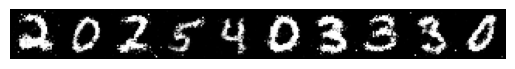

In [125]:
import matplotlib.pyplot as plt
generator.eval()
discriminator.eval()
generator.load('generator_last.pkl')
discriminator.load('discriminator_last.pkl')

number = "2025403330" #TODO(5): 写入你的学号（字符串类型）
n_row = len(number)
z = jt.array(np.random.normal(0, 1, (n_row, latent_dim))).float32().stop_grad()
labels = jt.array(np.array([int(number[num]) for num in range(n_row)])).float32().stop_grad()
gen_imgs = generator(z,labels)

img_array = gen_imgs.data.transpose((1,2,0,3))[0].reshape((gen_imgs.shape[2], -1))
min_=img_array.min()
max_=img_array.max()
img_array=(img_array-min_)/(max_-min_)*255

fig, ax = plt.subplots()
ax.imshow(img_array, cmap='gray')
ax.axis('off')

fig.patch.set_visible(False)
plt.savefig('result.png')
